# Setup


## Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import random
random.seed(123)

import time
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Check CUDA version

In [ ]:

use_cuda = True

if use_cuda and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

device

device(type='cuda')

## Visualisation functions

In [ ]:

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Function to show an image tensor
def show(X, c):
    if X.dim() == 3 and X.size(2) == 3:
        plt.imshow(X.numpy())
        #plt.show()
    elif X.dim() == 2:
        plt.imshow(   X.numpy() , cmap= c  )
        #plt.show()
    else:
        print('WRONG TENSOR SIZE')

## Download dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.squeeze()),  # Squeeze the data to remove the redundant channel dimension
                                ])

trainset = torchvision.datasets.FashionMNIST(root='./data_FashionMNIST',
                                      train=True,
                                      download=True,
                                      transform=transform
                                      )

testset = torchvision.datasets.FashionMNIST(root='./data_FashionMNIST',
                                     train=False,
                                     download=True,
                                     transform=transform
                                     )

classes = (
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
)

## Create train/val/test sets

In [ ]:
from sklearn.model_selection import train_test_split
targets = trainset.targets
train_idx, val_idx= train_test_split(np.arange(len(targets)),test_size=0.2,shuffle=True, stratify=targets, random_state=123)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

batch_size=128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=val_sampler)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True
                                         )

# Model architecture

## Create the model

In [ ]:
class Net(nn.Module):

    def __init__(self, kernel_size, pool_function, nfilters_conv1, nfilters_conv2):

        super(Net, self).__init__()
        self.nfilters_conv2 = nfilters_conv2

        # CL1:   1 x 28 x 28 (grayscale) -->    nfilters_conv1 x 28 x 28 
        self.conv1 = nn.Conv2d(1, nfilters_conv1,  kernel_size=kernel_size,  padding=kernel_size//2)

        # MP1: nfilters_conv1 x 28 x 28  -->    nfilters_conv1 x 14 x 14
        self.pool1  = pool_function(2,2)
        
        # CL2:   nfilters_conv1 x 14 x 14  -->    nfilters_conv2 x 14 x 14
        self.conv2 = nn.Conv2d(nfilters_conv1,  nfilters_conv2,  kernel_size=kernel_size,  padding=kernel_size//2)
        
        # MP2:  nfilters_conv2 x 14 x 14 -->    nfilters_conv2 x 7 x 7
        self.pool2 = pool_function(2,2)
        
        # LL1:   nfilters_conv2 x 7 x 7 -->  100 
        self.linear1 = nn.Linear((nfilters_conv2*7*7), 100)
        
        # LL2:   100  -->  10 
        self.linear2 = nn.Linear(100,10)


    def forward(self, x):
        x = x.unsqueeze(1)

        # CL1:   
        x = self.conv1(x)
        x = F.relu(x)
        
        # MP1: 
        x = self.pool1(x)
        
        # CL2:   
        x = self.conv2(x)
        x = F.relu(x)
        
        # MP2: 
        x = self.pool2(x)

        # LL1:   
        x = x.view(-1, self.nfilters_conv2*7*7)
        x = self.linear1(x)
        x = F.relu(x)
        
        # LL2:  
        x = self.linear2(x)
    
        return x

In [ ]:
model = torch.load("/content/drive/MyDrive/Deep Learning/Project/model.pckl")

In [ ]:
print(model)

LeNet(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (linear1): Linear(in_features=6272, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
)


# Attack!

## Import libraries

In [ ]:
!pip install advertorch

In [ ]:
from advertorch.attacks import PGDAttack

## Create adversary 

In [ ]:
# prepare attack instance

adversary = PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(), eps=0.3,
    nb_iter=10, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=False)


# Qualitative evaluation

## Set random sample

In [ ]:
random.seed(321)
sample_ids = random.sample(range(len(trainset)), 10)

In [ ]:
cln_data = torch.Tensor()
true_label = []

# Perturb images

In [ ]:
for id in sample_ids:
  cln_data = torch.cat((trainset[id][0].unsqueeze(2), cln_data), dim=-1)
  true_label.append(trainset[id][1])

cln_data = cln_data.transpose(0,2)
cln_data = cln_data.transpose(1,2)
true_label = torch.as_tensor(true_label)

cln_data, true_label = cln_data.to(device), true_label.to(device)
adv_untargeted = adversary.perturb(cln_data, true_label)

In [ ]:
from advertorch.utils import predict_from_logits
pred_cln = predict_from_logits(model(cln_data))
pred_untargeted_adv = predict_from_logits(model(adv_untargeted))

## Show perturbed images

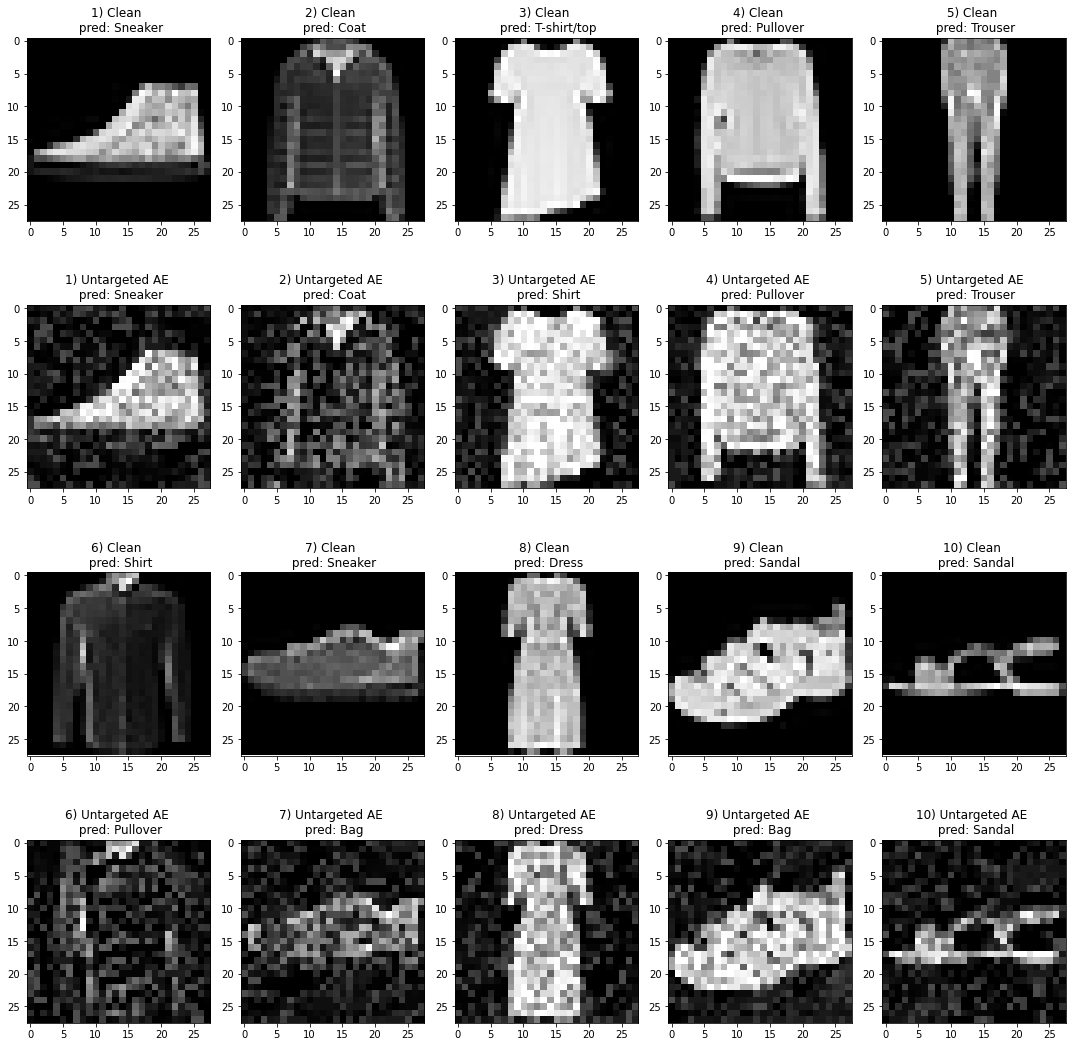

In [ ]:
plt.figure(figsize=(15, 15))
for ii in range(5):
    plt.subplot(4, 5, ii + 1)
    show(cln_data[ii].cpu(), c='gray')
    plt.title(str(ii+1)+ ") Clean \n pred: {}".format(classes[pred_cln[ii]]))
    plt.subplot(4, 5, ii + 5 + 1)
    show(adv_untargeted[ii].cpu(), c='gray')
    plt.title(str(ii+1)+") Untargeted AE \n pred: {}".format(classes[pred_untargeted_adv[ii]]))
    plt.subplot(4, 5, ii + 10 + 1)
    show(cln_data[ii+5].cpu(), c='gray')
    plt.title(str(ii+6)+") Clean \n pred: {}".format(classes[pred_cln[ii+5]]))
    plt.subplot(4, 5, ii + 15 + 1)
    show(adv_untargeted[ii+5].cpu(), c='gray')
    plt.title(str(ii+6) + ") Untargeted AE \n pred: {}".format(
        classes[pred_untargeted_adv[ii+5]]))

plt.tight_layout()
plt.show()

## Show image saliency

In [ ]:
def compute_saliency(X):
    X = X.reshape(1, 28, 28)
    X = X.to(device)
    X.requires_grad_()
    Y = model(X)
    Y_idx = Y.argmax()
    Y_max = Y[0, Y_idx]
    Y_max.backward()
    saliency, _ = torch.max(X.grad.data.abs(), dim=0) 
    saliency = saliency.reshape(28, 28)
    return saliency

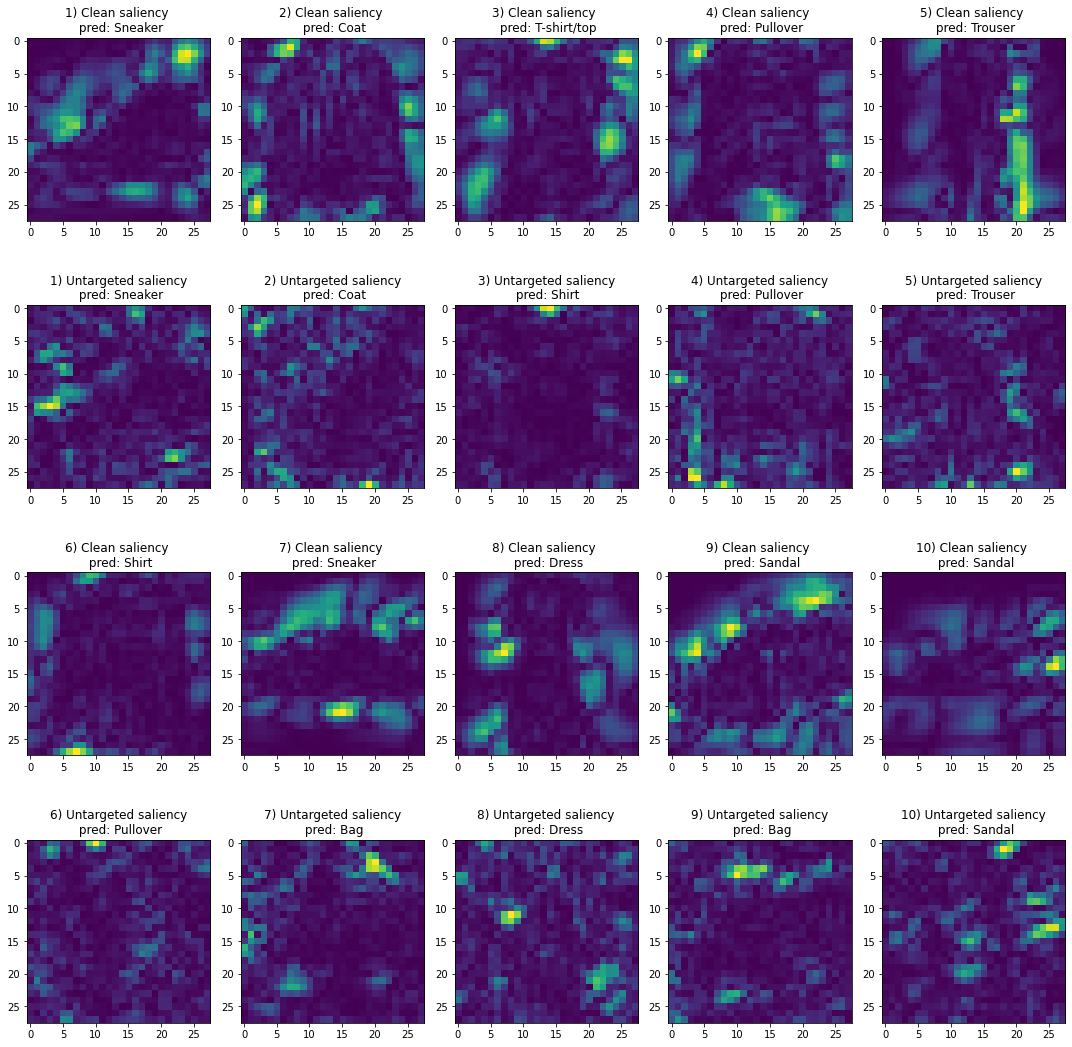

In [ ]:
plt.figure(figsize=(15,15))
for ii in range(5):
    plt.subplot(4, 5, ii + 1)
    s1 = compute_saliency(cln_data[ii])
    show(s1.cpu(), c='viridis')
    plt.title(str(ii+1) + ") Clean saliency \n pred: {}".format(classes[pred_cln[ii]]))
    plt.subplot(4, 5, ii + 5 + 1)
    s2 = compute_saliency(adv_untargeted[ii])
    show(s2.cpu(), c='viridis')
    plt.title(str(ii+1) + ") Untargeted saliency\n pred: {}".format(
        classes[pred_untargeted_adv[ii]]))
    plt.subplot(4, 5, ii + 10+ 1)
    s1 = compute_saliency(cln_data[ii+5])
    show(s1.cpu(), c='viridis')
    plt.title(str(ii+6) + ") Clean saliency \n pred: {}".format(classes[pred_cln[ii+5]]))
    plt.subplot(4, 5, ii + 15 + 1)
    s2 = compute_saliency(adv_untargeted[ii+5])
    show(s2.cpu(), c='viridis')
    plt.title(str(ii+6) + ") Untargeted saliency\n pred: {}".format(
        classes[pred_untargeted_adv[ii+5]]))

plt.tight_layout()
plt.show()

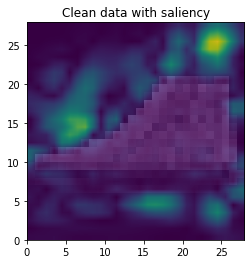

In [ ]:
# make these smaller to increase the resolution
dx, dy = 0.05, 0.05

x = np.arange(0., 28.0, dx)
y = np.arange(0., 28.0, dy)
X, Y = np.meshgrid(x, y)

# when layering multiple images, the images need to have the same
# extent.  This does not mean they need to have the same shape, but
# they both need to render to the same coordinate system determined by
# xmin, xmax, ymin, ymax.  Note if you use different interpolations
# for the images their apparent extent could be different due to
# interpolation edge effects

extent = np.min(x), np.max(x), np.min(y), np.max(y)
fig = plt.figure(frameon=False)

Z1 = cln_data[0].cpu().numpy()
im1 = plt.imshow(Z1, cmap=plt.cm.gray, interpolation='nearest',
                 extent=extent)

Z2 = compute_saliency(cln_data[0]).cpu().numpy()

im2 = plt.imshow(Z2, cmap=plt.cm.viridis, alpha=.8, interpolation='bilinear',
                 extent=extent)
plt.title("Clean data with saliency")
plt.show()


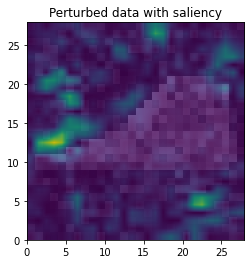

In [ ]:
fig = plt.figure(frameon=False)

Z1 = adv_untargeted[0].cpu().numpy()
im1 = plt.imshow(Z1, cmap=plt.cm.gray, interpolation='nearest',
                 extent=extent)

Z2 = compute_saliency(adv_untargeted[0]).cpu().numpy()

im2 = plt.imshow(Z2, cmap=plt.cm.viridis, alpha=.8, interpolation='bilinear',
                 extent=extent)
plt.title("Perturbed data with saliency")
plt.show()

# Testing


## Test model on clean data

In [ ]:
correct_total = 0

for i, (x_batch, y_batch) in enumerate(testloader):
  x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

  y_pred = model(x_batch)
  y_pred_max = torch.argmax(y_pred, dim=1)

  correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

print(f'Accuracy on the test set: {correct_total / len(testset):.3f}')

Accuracy on the test set: 0.899


## Test model on perturbed data

In [ ]:
import pandas as pd
import seaborn as sn

In [ ]:
correct_total = 0
all_preds = []
y_true = []

for i, (x_batch, y_batch) in enumerate(testloader):
  x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used
  y_true.extend(y_batch)

  adv = adversary.perturb(x_batch, y_batch)

  y_adv_pred = predict_from_logits(model(adv))

  all_preds.extend(y_adv_pred)
  correct_total += torch.sum(torch.eq(y_adv_pred, y_batch)).item()

print(f'Accuracy on the test set: {correct_total / len(testset):.3f}')

Accuracy on the test set: 0.001


In [ ]:
accuracy = correct_total / len(testset)
z = 1.96 #for 95% CI
n = len(all_preds)

interval = z * np.sqrt( (accuracy * (1 - accuracy)) / n)
interval

0.0007067942151008311

## Visualise results

In [ ]:
y_true_int = [int(x.cpu()) for x in y_true]
y_pred_int = [int(x.cpu()) for x in all_preds]

In [ ]:
data = {'y_Actual':    y_true_int,
        'y_Predicted': y_pred_int
        }
cm_df = pd.DataFrame(data, columns=['y_Actual', 'y_Predicted'])

cm_df.head()

,y_Actual,y_Predicted
0,8,6
1,4,6
2,0,6
3,3,4
4,2,0


In [ ]:
confusion_matrix = pd.crosstab(cm_df['y_Actual'], cm_df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted    0   1    2    3    4    5    6   7    8    9
Actual                                                   
0            0  26  375  220  102    5  214   1   53    1
1           21   2   34  184  196    1  483   0   74    2
2           91  27    0  159  135    1  335   1  249    0
3           51  64  127    0  314    0  189   3  231   21
4           37  20  187   92    0    1  507   1  154    0
5            0  39   79   16    0    0   50  33  552  230
6           62  31  220  102  240    5    0   0  338    1
7           11  19   49   70    0  110   23   0  584  134
8          125  36  282   75   18   29  385   7   11   29
9            3  31   58   27   17   71  191   6  594    0


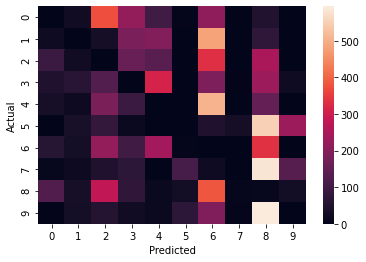

In [ ]:
sn.heatmap(confusion_matrix, annot=False)
plt.show()

# Confidence of misclassifcation rate of adversarial attack

In [ ]:
# list of all perturbed images 
# - images that are misclassified
# -- loss of each misclassified image
loss_misclassified = []
from advertorch.utils import predict_from_logits

In [ ]:
for i, (x_batch, y_batch) in enumerate(testloader):
  x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

  adv = adversary.perturb(x_batch, y_batch)

  y_adv_pred = model(adv)

  prob = nn.functional.softmax(model(adv), dim=1)

  for pred, label in zip(prob, y_batch):
    if torch.argmax(pred) != label: 
      loss_misclassified.append(pred[torch.argmax(pred)])


In [ ]:
loss_misclassified

[tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(0.9613, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(0.7012, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(0.9538, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(0.8377, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(0.9226, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(0.9065, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(0.4351, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(0.9993, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(0.9954, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(0.5585, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(0.9389, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(1., device='cuda:0', grad_fn=<SelectBackward>),
 tensor(0.9979, device='cuda:0', grad_fn=<Se

In [ ]:
torch.mean(torch.stack(loss_misclassified))

tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
predict_from_logits(y_adv_pred)

tensor([8, 6, 2, 6, 8, 6, 6, 8, 6, 8, 8, 6, 8, 2, 6, 4, 2, 8, 8, 5, 9, 2, 3, 8,
        2, 4, 2, 4, 2, 5, 4, 2, 0, 6, 0, 2, 3, 9, 3, 3, 6, 8, 0, 4, 6, 6, 3, 6,
        2, 2, 4, 6, 2, 4, 6, 6, 2, 6, 5, 4, 5, 8, 2, 1, 2, 1, 8, 9, 2, 8, 8, 8,
        1, 8, 6, 9, 1, 2, 8, 6, 8, 8, 8, 8, 9, 3, 5, 1, 8, 2, 8, 8, 3, 6, 8, 1,
        8, 3, 2, 8, 6, 8, 6, 6, 8, 6, 8, 2, 8, 3, 3, 8, 2, 8, 1, 4, 3, 2, 8, 4,
        8, 3, 6, 0, 3, 6, 8, 4], device='cuda:0')